In [1]:
import fastai
from fastai.vision.all import *
import pandas as pd

In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score,balanced_accuracy_score
import numpy as np

In [3]:
sls = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/3200_sls.csv")

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
sls.head()

,id,kdprov,kdkab,kdkec,kddesa,iddesa,idslsnon,nmslsnon,ketua_sls,jenis,...,j_bstt,j_bsbtt,j_bstt_k,j_bskeko,j_segmen,dom,ldom,j_m_all,j_m_30,klas_ur
0,263884,32,1,10,1,3201010001,100,RT 001 RW 001 DUSUN 1,MUHAMAD RAFLI HIDAYAT,1,...,39,1,2,4,1,1,1,51,51,2
1,263885,32,1,10,1,3201010001,200,RT 002 RW 001 DUSUN 1,NURMAN,1,...,60,2,0,7,1,1,1,62,61,2
2,263886,32,1,10,1,3201010001,300,RT 003 RW 001 DUSUN 1,SAENUDIN,1,...,50,2,0,6,1,1,1,58,57,2
3,263887,32,1,10,1,3201010001,400,RT 004 RW 001 DUSUN 1,AEP,1,...,27,1,0,1,1,1,1,31,31,2
4,263888,32,1,10,1,3201010001,500,RT 005 RW 001 DUSUN 1,JEJEN JAELANI,1,...,49,7,3,8,3,1,1,63,57,2


In [4]:
sls.iddesa.unique().shape

(5957,)

In [92]:
os.chdir('C:/Users/jwst2/Python/tesis/jpg/urbanrural/10. Sentinel 10M Desa ES')
if os.path.isdir('urban') is False:
    os.makedirs('urban')
    os.makedirs('rural')

In [93]:
yourpath = "C:/Users/jwst2/Python/tesis/jpg/general desa sentinel sq/"
from tqdm import tqdm
for root, dirs, files in tqdm(os.walk(yourpath, topdown=False)):
    for name in files:
        try :
            if(sls.klas_ur[sls.iddesa == int(name.replace(".jpg","")[:10])].iloc[0] == 1):
                shutil.copy(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/urbanrural/10. Sentinel 10M Desa ES/urban/"+name)
            elif(sls.klas_ur[sls.iddesa == int(name.replace(".jpg","")[:10])].iloc[0] == 2):
                shutil.copy(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/urbanrural/10. Sentinel 10M Desa ES/rural/"+name)
        except Exception:
            print(name)
            pass 

0it [00:00, ?it/s]

3207000000.jpg
3208000000.jpg
3208010000.jpg
3211080000.jpg
3211111000.jpg
3217000000.jpg


1it [00:26, 26.28s/it]


### Run Dataset

In [100]:
path = Path.cwd() / ("C:/Users/jwst2/Python/tesis/jpg/urbanrural/10. Sentinel 10M Desa ES/")

In [101]:
Path.BASE_PATH = path
path.ls()

(#2) [Path('rural'),Path('urban')]

In [102]:
fname = (path/"rural").ls()[0]
fname

Path('rural/3201010001.jpg')

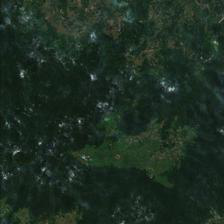

In [103]:
img = Image.open(fname)
img

In [104]:
blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=RandomSplitter(valid_pct=0.1, seed=42),  # default random split 80% training, 20% validation
                 get_y=parent_label, # extracts the label category from the image's folder name 
                 batch_tfms=aug_transforms(mult=2)) # data augmentation (mult multiplies the default transformation values)

In [109]:
dls = blocks.dataloaders(path, bs= 4)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


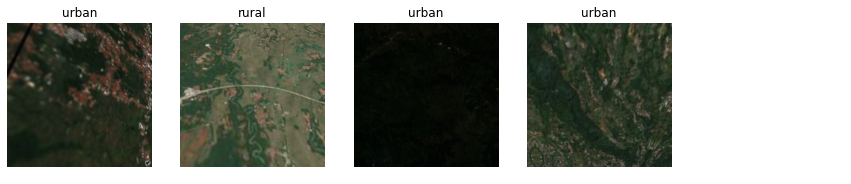

In [110]:
dls.show_batch(nrows=1, ncols=5)

In [111]:
avg = 'macro'
roca = RocAucBinary(average=avg)
f1s = F1Score(average=avg)
bc = BalancedAccuracy()
metrics=[accuracy,bc, Precision(average=avg), Recall(average=avg), f1s, roca]
learn = cnn_learner(dls, densenet121, metrics=metrics) 

In [112]:
learn.lr_find()

RuntimeError: CUDA out of memory. Tried to allocate 14.00 MiB (GPU 0; 4.00 GiB total capacity; 2.03 GiB already allocated; 0 bytes free; 2.06 GiB reserved in total by PyTorch)

In [13]:
learn.unfreeze()

In [22]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.436201,0.394196,0.818719,0.667193,0.732174,0.667193,0.688131,0.833504,15:28
1,0.389233,0.370661,0.823470,0.686601,0.739059,0.686601,0.705607,0.852366,13:16
2,0.387598,0.369257,0.824986,0.651225,0.757148,0.651225,0.677218,0.855345,13:02
3,0.385268,0.371153,0.824481,0.702767,0.738747,0.702767,0.717345,0.856957,13:08
4,0.361183,0.360882,0.826856,0.681466,0.748338,0.681466,0.703760,0.860220,13:11
5,0.377206,0.360311,0.826755,0.669087,0.752864,0.669087,0.693856,0.861242,13:20
6,0.376911,0.358095,0.826907,0.670311,0.752747,0.670311,0.694949,0.862589,13:19
7,0.365888,0.359787,0.827665,0.669144,0.755526,0.669144,0.694383,0.863660,13:25
8,0.363157,0.356492,0.827665,0.670619,0.754813,0.670619,0.695607,0.864170,13:32
9,0.374349,0.356720,0.828221,0.668283,0.757652,0.668283,0.693954,0.864589,13:34


In [23]:
dls.vocab

['rural', 'urban']

In [24]:
dls.train.items[175000]

Path('urban/32100900170013.jpg')

In [25]:
learn.export('C:/Users/jwst2/Python/tesis/models/19042020 D003.pkl')

### Up level

In [26]:
idx_train = []
for i in dls.train.items:
    idx_train.append(str(i)[-18:-4])
true_label = []
for i in dls.train.items:
    if("urban" in str(i)) :
        true_label.append(1)
    else :
        true_label.append(0)

In [27]:
preds,_ = learn.get_preds(ds_idx  = 0)
result_train = preds.numpy()
new_train = pd.DataFrame(result_train)

In [28]:
pd.value_counts(true_label)

1    140272
0     37820
dtype: int64

In [29]:
df = new_train
df["idsls"] = idx_train 
df["stat"] = round(df[1])
df["iddesa"] = df.idsls.str[:10]
df.head()

,0,1,idsls,stat,iddesa
0,0.002962,0.997038,32731000020061,1.0,3273100002
1,0.063439,0.936561,32150500070004,1.0,3215050007
2,0.258244,0.741756,32022100131006,1.0,3202210013
3,0.077709,0.922291,32081500110025,1.0,3208150011
4,0.184460,0.815540,32110500010021,1.0,3211050001


In [30]:
pd.value_counts(df.stat)

1.0    155654
0.0     22438
Name: stat, dtype: int64

In [31]:
df["true_lab"] = true_label

In [32]:
pd.value_counts(df.true_lab)

1    140272
0     37820
Name: true_lab, dtype: int64

In [33]:
accuracy_score(df.stat.apply(int),df.true_lab.apply(int))

0.8276845675268962

In [34]:
df.head()

,0,1,idsls,stat,iddesa,true_lab
0,0.002962,0.997038,32731000020061,1.0,3273100002,1
1,0.063439,0.936561,32150500070004,1.0,3215050007,1
2,0.258244,0.741756,32022100131006,1.0,3202210013,1
3,0.077709,0.922291,32081500110025,1.0,3208150011,1
4,0.184460,0.815540,32110500010021,1.0,3211050001,1


In [35]:
desa_pred = df.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})

In [36]:
desa_pred.columns = ["pred","true"]

In [37]:
pd.value_counts(df.stat)

1.0    155654
0.0     22438
Name: stat, dtype: int64

In [38]:
for i in np.arange(0.1, 0.95, 0.05):
    value = round(i,2)
    desa_pred["label"+str(value)] = 0
    desa_pred["label"+str(value)][desa_pred.pred > value] = 1

C:\Users\jwst2\AppData\Local\Temp/ipykernel_25336/4109382162.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desa_pred["label"+str(value)][desa_pred.pred > value] = 1


In [39]:
desa_pred.head()

,pred,true,label0.1,label0.15,label0.2,label0.25,label0.3,label0.35,label0.4,label0.45,label0.5,label0.55,label0.6,label0.65,label0.7,label0.75,label0.8,label0.85,label0.9
iddesa,,,,,,,,,,,,,,,,,,,
3201010001,0.293103,0.0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3201010002,0.782609,0.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0
3201010003,0.605263,1.0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0
3201010004,0.875000,0.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
3201010005,0.833333,1.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0


In [40]:
for j in range(2,19):
    print("result", desa_pred.columns[j])
    print("accuracy :",  accuracy_score( desa_pred.true,desa_pred.iloc[:,[j]]))
    print("precision :",  precision_score( desa_pred.true,desa_pred.iloc[:,[j]]))

result label0.1
accuracy : 0.7420738530399105
precision : 0.7373447946513849
result label0.15
accuracy : 0.747668780305856
precision : 0.7428074917937826
result label0.2
accuracy : 0.7556881760537113
precision : 0.7495122902848225
result label0.25
accuracy : 0.7642670645281612
precision : 0.7574139976275207
result label0.3
accuracy : 0.7694889966430436
precision : 0.762779552715655
result label0.35
accuracy : 0.7765759045132413
precision : 0.7700242718446602
result label0.4
accuracy : 0.7849682954121596
precision : 0.7785758259798892
result label0.45
accuracy : 0.7900037299515106
precision : 0.7847943498130453
result label0.5
accuracy : 0.7965311450951138
precision : 0.7939868727503705
result label0.55
accuracy : 0.8008205893323387
precision : 0.8004291845493562
result label0.6
accuracy : 0.804177545691906
precision : 0.8080454744206383
result label0.65
accuracy : 0.8082804923535994
precision : 0.8172475424486149
result label0.7
accuracy : 0.8108914584110407
precision : 0.8272935779816

In [41]:
from sklearn.metrics import confusion_matrix

In [42]:
pd.value_counts(desa_pred.true)

1.0    3868
0.0    1494
Name: true, dtype: int64

### Test result

In [43]:
path_pred = Path.cwd() / ("C:/Users/jwst2/Python/tesis/jpg/sls 10m test")
test_files = [fn for fn in sorted((path_pred).glob('**/*')) if fn.is_file()]

In [44]:
len(test_files)

22054

In [45]:
test_dl = learn.dls.test_dl(test_files)

In [46]:
preds,_ = learn.get_preds(dl  =test_dl)

In [47]:
str(test_files[1])[-18:-4]

'32011500010002'

In [48]:
idx_test = []
for i in test_files:
    idx_test.append(str(i)[-18:-4])
true_label = []
for i in test_files:
    if("urban" in str(i)) :
        true_label.append(1)
    else :
        true_label.append(0)

In [49]:
test = pd.DataFrame(preds)

In [50]:
test["idsls"] = idx_test
test["true_lab"] = true_label

In [51]:
test["iddesa"] = test.idsls.str[:10]
test["stat"] = round(test[1])

In [52]:
test.head()

,0,1,idsls,true_lab,iddesa,stat
0,0.716636,0.283364,32011500010001,0,3201150001,0.0
1,0.644514,0.355486,32011500010002,0,3201150001,0.0
2,0.594599,0.405401,32011500010003,0,3201150001,0.0
3,0.525474,0.474526,32011500010004,0,3201150001,0.0
4,0.558865,0.441135,32011500010005,0,3201150001,0.0


In [53]:
desa_pred_test = test.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})

In [54]:
desa_pred_test

,stat,true_lab
,mean,mean
iddesa,,
3201010010,0.857143,1.0
3201040001,1.000000,1.0
3201040005,1.000000,1.0
3201050012,1.000000,1.0
3201050013,1.000000,1.0
...,...,...
3278050003,1.000000,1.0
3278071005,1.000000,1.0


In [55]:
desa_pred_test.columns = ["pred","true"]

In [56]:
desa_pred_test["pred_lab"] = 0
desa_pred_test["pred_lab"][desa_pred_test.pred > 0.775] = 1

C:\Users\jwst2\AppData\Local\Temp/ipykernel_25336/2742235302.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desa_pred_test["pred_lab"][desa_pred_test.pred > 0.775] = 1


In [57]:
desa_pred_test

,pred,true,pred_lab
iddesa,,,
3201010010,0.857143,1.0,1
3201040001,1.000000,1.0,1
3201040005,1.000000,1.0,1
3201050012,1.000000,1.0,1
3201050013,1.000000,1.0,1
...,...,...,...
3278050003,1.000000,1.0,1
3278071005,1.000000,1.0,1
3278080002,1.000000,1.0,1


In [60]:
print("accuracy :",  accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("balanced_accuracy_score :",  balanced_accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("precision :",  precision_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("recall :",  recall_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("f1 :",  f1_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("rocauc :",  roc_auc_score( desa_pred_test.true,desa_pred_test.pred_lab))

accuracy : 0.8184873949579832
balanced_accuracy_score : 0.7381440281030445
precision : 0.8400852878464818
recall : 0.9227166276346604
f1 : 0.8794642857142857
rocauc : 0.7381440281030446


### Resnet

In [61]:
learn_rs = cnn_learner(dls, resnet50, metrics=metrics) 

In [62]:
learn_rs.unfreeze()

In [63]:
learn_rs.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.438289,0.397815,0.812655,0.584073,0.775932,0.584073,0.594586,0.831157,11:53
1,0.430301,0.665962,0.818366,0.642685,0.739663,0.642685,0.666311,0.820053,11:35
2,0.399390,0.400845,0.815990,0.665807,0.726041,0.665807,0.685624,0.833848,11:21
3,0.371089,0.370890,0.822510,0.659106,0.744876,0.659106,0.683213,0.849727,11:27
4,0.386146,0.371738,0.823318,0.659793,0.746969,0.659793,0.684202,0.849361,11:33


In [64]:
learn_rs.export('C:/Users/jwst2/Python/tesis/models/19042020 R003.pkl')

In [65]:
idx_train = []
for i in dls.train.items:
    idx_train.append(str(i)[-18:-4])
true_label = []
for i in dls.train.items:
    if("urban" in str(i)) :
        true_label.append(1)
    else :
        true_label.append(0)

In [66]:
preds,_ = learn_rs.get_preds(ds_idx  = 0)
result_train = preds.numpy()
new_train = pd.DataFrame(result_train)

In [67]:
df = new_train
df["idsls"] = idx_train 
df["stat"] = round(df[1])
df["iddesa"] = df.idsls.str[:10]
df.head()

,0,1,idsls,stat,iddesa
0,0.010298,0.989702,32731000020061,1.0,3273100002
1,0.038067,0.961933,32150500070004,1.0,3215050007
2,0.299616,0.700384,32022100131006,1.0,3202210013
3,0.037139,0.962861,32081500110025,1.0,3208150011
4,0.147126,0.852874,32110500010021,1.0,3211050001


In [68]:
pd.value_counts(df.stat)

1.0    158105
0.0     19987
Name: stat, dtype: int64

In [69]:
df["true_lab"] = true_label

In [70]:
pd.value_counts(df.true_lab)

1    140272
0     37820
Name: true_lab, dtype: int64

In [71]:
accuracy_score(df.stat.apply(int),df.true_lab.apply(int))

0.8210531635334546

In [72]:
df.head()

,0,1,idsls,stat,iddesa,true_lab
0,0.010298,0.989702,32731000020061,1.0,3273100002,1
1,0.038067,0.961933,32150500070004,1.0,3215050007,1
2,0.299616,0.700384,32022100131006,1.0,3202210013,1
3,0.037139,0.962861,32081500110025,1.0,3208150011,1
4,0.147126,0.852874,32110500010021,1.0,3211050001,1


In [73]:
desa_pred = df.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})

In [74]:
desa_pred.columns = ["pred","true"]

In [75]:
pd.value_counts(df.stat)

1.0    158105
0.0     19987
Name: stat, dtype: int64

In [76]:
for i in np.arange(0.1, 0.95, 0.025):
    value = round(i,2)
    desa_pred["label"+str(value)] = 0
    desa_pred["label"+str(value)][desa_pred.pred > value] = 1

C:\Users\jwst2\AppData\Local\Temp/ipykernel_25336/935834860.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desa_pred["label"+str(value)][desa_pred.pred > value] = 1


In [77]:
desa_pred.head()

,pred,true,label0.1,label0.12,label0.15,label0.18,label0.2,label0.22,label0.25,label0.27,...,label0.7,label0.72,label0.75,label0.77,label0.8,label0.82,label0.85,label0.87,label0.9,label0.92
iddesa,,,,,,,,,,,,,,,,,,,,,
3201010001,0.189655,0.0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3201010002,0.717391,0.0,1,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
3201010003,0.710526,1.0,1,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
3201010004,0.875000,0.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
3201010005,0.900000,1.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0


In [78]:
for j in range(2,36):
    print("result", desa_pred.columns[j])
    print("accuracy :",  accuracy_score( desa_pred.true,desa_pred.iloc[:,[j]]))
    print("precision :",  precision_score( desa_pred.true,desa_pred.iloc[:,[j]]))

result label0.1
accuracy : 0.7351734427452443
precision : 0.7318181818181818
result label0.12
accuracy : 0.7370384185005595
precision : 0.7333839726547664
result label0.15
accuracy : 0.7405818724356583
precision : 0.73630986452967
result label0.18
accuracy : 0.7441253263707572
precision : 0.739355581127733
result label0.2
accuracy : 0.7467362924281984
precision : 0.7416249518675395
result label0.22
accuracy : 0.7471092875792614
precision : 0.7423774604399845
result label0.25
accuracy : 0.7525177172696755
precision : 0.7470348045887614
result label0.27
accuracy : 0.7534502051473331
precision : 0.7481481481481481
result label0.3
accuracy : 0.7569936590824319
precision : 0.7517173699705594
result label0.32
accuracy : 0.7607236105930623
precision : 0.755081902506414
result label0.35
accuracy : 0.7644535621036926
precision : 0.7586891757696127
result label0.37
accuracy : 0.7659455427079448
precision : 0.7603108188882247
result label0.4
accuracy : 0.7717269675494218
precision : 0.76578206674

### Test result resnet

In [79]:
path_pred = Path.cwd() / ("C:/Users/jwst2/Python/tesis/jpg/sls 10m test")
test_files = [fn for fn in sorted((path_pred).glob('**/*')) if fn.is_file()]

In [80]:
test_dl = learn_rs.dls.test_dl(test_files)

In [81]:
preds,_ = learn_rs.get_preds(dl  =test_dl)

In [82]:
idx_test = []
for i in test_files:
    idx_test.append(str(i)[-18:-4])
true_label = []
for i in test_files:
    if("urban" in str(i)) :
        true_label.append(1)
    else :
        true_label.append(0)

In [83]:
test = pd.DataFrame(preds)

In [84]:
test["idsls"] = idx_test
test["true_lab"] = true_label

In [85]:
test["iddesa"] = test.idsls.str[:10]
test["stat"] = round(test[1])

In [86]:
test.head()

,0,1,idsls,true_lab,iddesa,stat
0,0.635516,0.364484,32011500010001,0,3201150001,0.0
1,0.565740,0.434260,32011500010002,0,3201150001,0.0
2,0.561585,0.438415,32011500010003,0,3201150001,0.0
3,0.562635,0.437365,32011500010004,0,3201150001,0.0
4,0.317222,0.682778,32011500010005,0,3201150001,1.0


In [87]:
desa_pred_test = test.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})

In [88]:
desa_pred_test.columns = ["pred","true"]

In [89]:
desa_pred_test["pred_lab"] = 0
desa_pred_test["pred_lab"][desa_pred_test.pred > 0.775] = 1

C:\Users\jwst2\AppData\Local\Temp/ipykernel_25336/2742235302.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desa_pred_test["pred_lab"][desa_pred_test.pred > 0.775] = 1


In [90]:
print("accuracy :",  accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("balanced_accuracy_score :",  balanced_accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("precision :",  precision_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("recall :",  recall_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("f1 :",  f1_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("rocauc :",  roc_auc_score( desa_pred_test.true,desa_pred_test.pred_lab))

accuracy : 0.8218487394957983
balanced_accuracy_score : 0.7459016393442623
precision : 0.8451612903225807
recall : 0.9203747072599532
f1 : 0.8811659192825113
rocauc : 0.7459016393442622


In [91]:
accuracy : 0.8218487394957983
balanced_accuracy_score : 0.7459016393442623
precision : 0.8451612903225807
recall : 0.9203747072599532
f1 : 0.8811659192825113
rocauc : 0.7459016393442622